In [190]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _canoeValues as cv

#-------------------Inputs-------------------------------------------------------------
script = "Longitudinal Analysis_4 Paddler.ipynb"
input_file = "Station Information.csv"
outerHull_file = "Outer Hull.csv" # Will be used for hydrostatic force and waterline calculation
DLF = cv.DLF # Dead Load Factor
LLF = 1.3 # Live Load Factor
pad_weights = cv.pad_weights # Weight of paddlers (kg)
water_den = cv.water_density # Density of water = 1000 kg/m^3
#--------------------------------------------------------------------------------------
# Acquire the waterline from grasshopper
grasshopper = cv.grasshopper[2] # [mm]

pad1_po = 1150 # Position of first paddler with respect to left end of canoe (mm)
pad2_po = 2400 # Position of second paddler with respect to left end of canoe (mm)
pad3_po = 3625 # Position of third paddler with respect to left end of canoe (mm)
pad4_po = 4775 # Position of fourth paddler with respect to left end of canoe (mm)
# Choose between pad_weights
pad_first = pad_weights[2]
pad_second = pad_weights[3]
pad_third = pad_weights[3]
pad_fourth = pad_weights[0]
pad1 = pad_first*LLF
pad2 = pad_second*LLF
pad3 = pad_third*LLF
pad4 = pad_fourth*LLF
#--------------------------------------------------------------------------------------

script_dir = os.path.abspath('data') # absolute file path in Jupyter
file_path = os.path.join(script_dir, input_file) # file path for the text file input

# Get the canoe's volume and mass from the station info
canoe_info = pd.read_csv(file_path, header=None)
statVol = canoe_info[1][1:]
statMass = canoe_info[2]

# Get the outer hull coordinates from the input file
file_path = os.path.join(script_dir, outerHull_file) 
out_coor = pd.read_csv(file_path, header=None)
x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

# Get the mass and volume at each station from the Station Information csv file (exported from Approximation-Vol Diff)
stat_Mass = []
for i in range(1,len(statMass),1):
    stat_Mass.append(float(statMass[i]))

stat_Vol = []
for i in range(1,len(statVol),1):
    stat_Vol.append(float(statVol[i]))

canoe_volume = np.sum(stat_Vol) # m^3
canoe_weight = np.sum(stat_Mass) #[kg]
total_weight = canoe_weight*DLF + pad1 + pad2 + pad3 + pad4 #[kg]

station_no = x_out.nunique() # number of stations
station = x_out.unique() # location of each station

In [191]:
# Outer Hull Volume
vol_out = []

# Loop through each station
# The loop ends at station_no - 2 because each loop uses the kth and the (k+1)th station
# Starts at 1 to skip 0,0,0
for k in range(1,station_no-2,1):
    
    # Coordinates of points in the outer frame sharing an X-coordinate with the current station
    X1_value = station[k]
    Y1 = []
    Z1 = []
    
    # Coordinates of points in the outer frame sharing an X-coordinates with the next station
    X2_value = station[k+1]
    Y2 = []
    Z2 = []

    # Loop through each X-coordinate in the outer hull
    for i in range(0,len(x_out),1):
        
        # If the coordinate is alignedd with the second station on the X-axis, store this XYZ coordinate
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])

        # Otherwise, if the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    
    volume = 0
    #Only perform ____ if there is a point on there currently
    if len(Y1)/2 == 0:
        n = int(len(Y1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
    else:
        n = int((len(Y1)-1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        # triangle piece at the bottom
        area1 = abs(Y1[n-1])*abs(Z1[n-1])/2*2
        area2 = abs(Y2[n-1])*abs(Z2[n-1])/2*2
        volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        vol_out.append(volume)

outer_volume = np.sum(vol_out)/10**9 #[m^3]

In [192]:
canoe_depth = max(abs(z_out)) 
waterline = canoe_depth - grasshopper # distance from the water surface to the bottom of canoe [mm]
increment = 1 # push down waterline by [] mm
water_weight = outer_volume*water_den # Assume canoe is fully submerged in water

#while water_weight - total_weight > 10:
vol_out = []
for k in range(1,station_no-2,1):
    X1_value = station[k]
    X2_value = station[k+1]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []

    #For all outer hull x-coordinates, if the x-coordinate is equal to the x-coordinate of the kth and k+1 stations, store the x, y, and z coordinates of that outer hull coordinate
    for i in range(0,len(x_out),1):
        if canoe_depth - abs(z_out[i]) <= waterline:
            if x_out[i] == X1_value:
                Y1.append(y_out[i])
                Z1.append(z_out[i])

            elif x_out[i] == X2_value:
                Y2.append(y_out[i])
                Z2.append(z_out[i])
    
    Y1.insert(0, Y1[0])
    Y1.append(Y1[len(Y1)-1])
    Z1.insert(0, waterline - canoe_depth)
    Z1.append(waterline - canoe_depth)
    
    Y2.insert(0, Y2[0])
    Y2.append(Y2[len(Y2)-1])
    Z2.insert(0, waterline - canoe_depth)
    Z2.append(waterline - canoe_depth)
    
    
    volume = 0
    # If outer hull x-coordinates that matched the station x-coordinates were found, then the volume of water will be calculated using the formulae below (this takes the area between the coordinates to calculate volume)
    if len(Y1)/2 == 0:
        n = int(len(Y1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
    else:
        n = int((len(Y1)-1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        # triangle piece at the bottom
        area1 = abs(Y1[n-1])*abs(Z1[n-1])/2*2
        area2 = abs(Y2[n-1])*abs(Z2[n-1])/2*2
        volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        vol_out.append(volume)

# From here to calculating water_colume is the same as above loop but only for the very ends of the canoe (calculated separately)
# Volumes of decks
X1_value = station[0]
X2_value = station[0+1]
Y1 = []
Y2 = []
Z1 = []
Z2 = []

# For all outer hull x-coordinates, if the x-coordinate is equal to the x-coordinates of the first and second stations, store the x, y, and z coordinates of that outer hull coordinate (identical to first loop but different volume calculations)
for i in range(0,len(x_out),1):
    if x_out[i] == X1_value:
        Y1.append(y_out[i])
        Z1.append(z_out[i])

    if canoe_depth - abs(z_out[i]) <= waterline:
        if x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

# Calculates volume of water using the saved coordinates above
l = abs(max(Y2)-min(Y2))
w = abs(max(Z2)-min(Z2))
h = abs(X2_value - X1_value)
volume = l*w*h/3
vol_out.insert(0, volume)

X1_value = station[len(station)-1]
X2_value = station[len(station)-2]
Y1 = []
Y2 = []
Z1 = []
Z2 = []

# For all outer hull x-coordinates, if the x-coordinate is equal to the x-coordinates of the last and second-to-last stations, store the x, y, and z coordinates of that outer hull coordinate (identical to first loop but different volume calculations)
for i in range(0,len(x_out),1):
    if x_out[i] == X1_value:
        Y1.append(y_out[i])
        Z1.append(z_out[i])
        
    if canoe_depth - abs(z_out[i]) <= waterline:
        if x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

# Calculates the volume of water using the saved coordinates above
l = abs(max(Y2)-min(Y2))
w = abs(max(Z2)-min(Z2))
h = abs(X2_value - X1_value)
volume = l*w*h/3
vol_out.append(volume)

# Combines the calculated water volumes above into a total water volume
water_volume = np.sum(vol_out)/10**9 #[m^3]

# Water weight = water volume (above) multiplied by the water density (constant defined at the start of the program. Can be changed on line 15)
water_weight = water_volume*water_den
    
    #waterline = waterline - increment

print('The depth of water is ', waterline, ' mm.')
print('The waterline is at', canoe_depth-waterline, 'mm.')
print('The weight of water is ', water_weight, 'kg.')
print('The total weight is ', total_weight, 'kg.')

The depth of water is  200.0  mm.
The waterline is at 140.0 mm.
The weight of water is  412.05720203281925 kg.
The total weight is  484.78971210058285 kg.


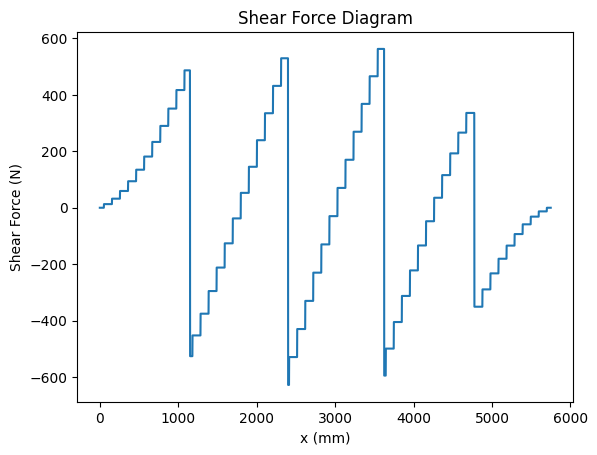

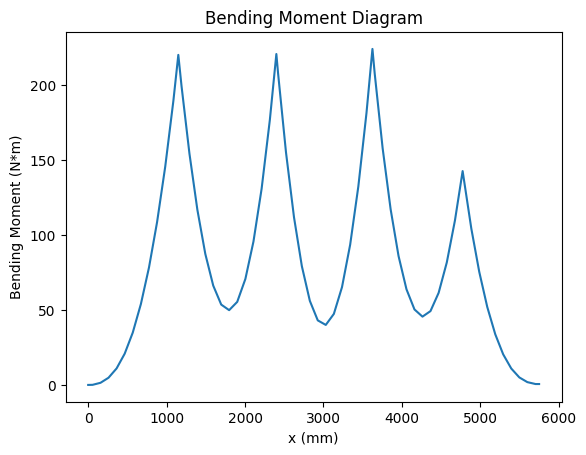

Maximum positive shear is  562.5284204443867 N.
Maximum negative shear is  -627.4881714967905 N.
Maximum positive moment is  224.0253052028181 Nm.
Maximum negative moment is  0 Nm.
Moment at the end is  0.5903071691769877 Nm.


In [193]:
difference = water_weight - total_weight
vol_mass = []

for i in range(0,len(vol_out),1):
    mass = (vol_out[i]/10**9)*water_den - difference/len(vol_out)
    vol_mass.append(mass)
    
# Plot SFD and BMD
pad_weight = [pad1, pad2, pad3, pad4]

length = max(x_out)
pad_po = [pad1_po, pad2_po, pad3_po, pad4_po]

# Make an array containing the middle x-coordinate of each station
stat_x = []
for i in range(0,len(station)-1,1):
    stat_x.append((station[i]+station[i+1])/2)

# Calculate the shear force
g = 9.81
x = []
shear = []

# Loop through the length of the canoe
for i in range(0,int(length),1):
    # Append the current distance travelled along the length of the canoe onto x
    x.append(i)
    
    #Calculate the shear force for this station
    shear_force = 0
    
    # Loop through each station
    for j in range(0,len(stat_x),1):
        if i >= stat_x[j]:
            shear_force  = shear_force + vol_mass[j]*g +(-1)*stat_Mass[j]*g*DLF
        else:
            shear_force = shear_force
    # Loop through each paddler
    for k in range(0,len(pad_po),1):
        if i >= pad_po[k]:
            shear_force = shear_force - pad_weight[k]*g
        else:
            shear_force = shear_force
    
    #Append the shear force summed at this length along the canoe
    shear.append(shear_force)

plt.plot(x,shear)
plt.title('Shear Force Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Shear Force (N)')
plt.show()

# Track mm distance of station for paddler positions
mm_traveled = 0
paddler_counter = 0

# Store Vf and paddlers? for csv file
Paddler_array = []
Station_by_length = []

for i in range(1,57):

    # Check if a paddler is in this station and calculate new distance travelled accordingly
    stationHasPaddler = False
    
    delta_mm_traveled = mm_traveled + float(canoe_info[4][i])

    # Any distance between the distance travelled (rounded) and the new distance travelled (larger due to more paddlers) (also rounded) will be saved. Anything else is discarded
    for j in range(round(mm_traveled), round(delta_mm_traveled)):
        Station_by_length.append(i)

    if(paddler_counter < len(pad_po)) and (mm_traveled <= pad_po[paddler_counter] and delta_mm_traveled > pad_po[paddler_counter]):
        stationHasPaddler = True
        paddler_counter += 1
    mm_traveled = delta_mm_traveled

    Paddler_array.append(stationHasPaddler)

# Export points to csv file (only calculates new bending moment -> outlined below):
df1 = pd.DataFrame(data={'Station': Station_by_length, 'Length': x, 'Shear': shear})

csv_file = 'Length_vs_Shear_4 Paddler.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)

moment = []
moment.append(0)
bending_moment = 0

# Calculates the new bending moment using shear
for i in range(1,len(x),1):
    bending_moment += (x[i]-x[i-1])*shear[i]/1000
    moment.append(bending_moment)

plt.plot(x,moment)
plt.title('Bending Moment Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Bending Moment (N*m)')
plt.show()

# Export points to csv file (only calculates maximum shear and moments -> outlined below):
df1 = pd.DataFrame(data={'Station': Station_by_length, 'Length': x, 'Moment': moment})

csv_file = 'Length_vs_Moment_4 Paddler.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)


shear_max_index = shear.index(max(shear))
#x(shear_max_index)

print('Maximum positive shear is ', max(shear), 'N.')
print('Maximum negative shear is ', min(shear), 'N.')
print('Maximum positive moment is ', max(moment), 'Nm.')
print('Maximum negative moment is ', min(moment), 'Nm.')
print('Moment at the end is ', moment[len(moment)-1],'Nm.')

In [194]:
# export the values to csv file (This code has nothing to do with calculaations, it only saves values so it can be ignored from a calcualation standpoint)
titles = ['Positive Shear [N]', 'Negative Shear [N]', 'Positive Bending Moment [Nm]', 'Negative Bending Moment [Nm]', 'Moment at the end [Nm]']
values = [max(shear), min(shear), max(moment), min(moment), moment[len(moment)-1]]
station_no = []
max_width = []
max_depth = []
station_t = [] # Station thickness

for value in [max(shear), min(shear)]:
    shear_index = shear.index(value)
    xshear = x[shear_index]
    for i in range(0,len(station)-1,1):
        if (xshear >= station[i] and xshear < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)
    station_t.append(abs(X2_value - X1_value))

for value in [max(moment), min(moment)]:
    moment_index = moment.index(value)
    xmoment = x[moment_index]
    for i in range(0,len(station)-1,1):
        if (xmoment >= station[i] and xmoment < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)
    station_t.append(abs(X2_value - X1_value))
    
station_no.append(len(station)-1)  
max_width.append('')
max_depth.append('')
station_t.append('')

df1 = pd.DataFrame(data={'': titles, 'Value': values, 'Station No': station_no, 'Max Width [mm]': max_width, 'Max Depth [mm]': max_depth, 'Station Thickness [mm]': station_t})

csv_file = 'Shear_and_Moment_4 Paddlers.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)



In [195]:
# Make a CSV file for buoyancy and gravity
# vol_mass (Array of force_buoyancy by station)
# stat_mass (Array of force_gravity by station)
df1 = pd.DataFrame(data={'Station No.': range(1, len(vol_mass) + 1, 1), 'Buoyancy Force [N]': [i * g for i in vol_mass], 'Self Weight': [i * g for i in stat_Mass] })

csv_file = 'Station_Loads_4 Paddlers.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)
print("Complete !")

Complete !


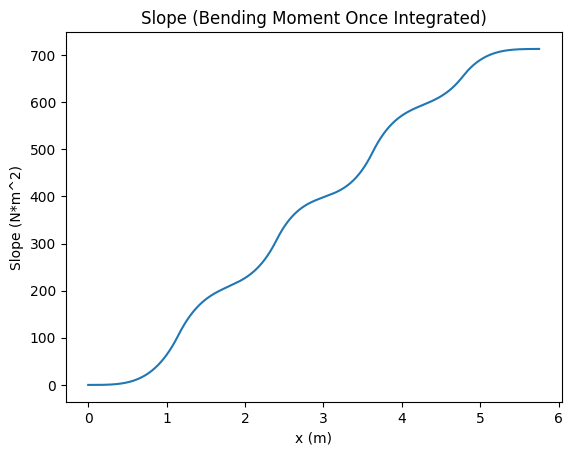

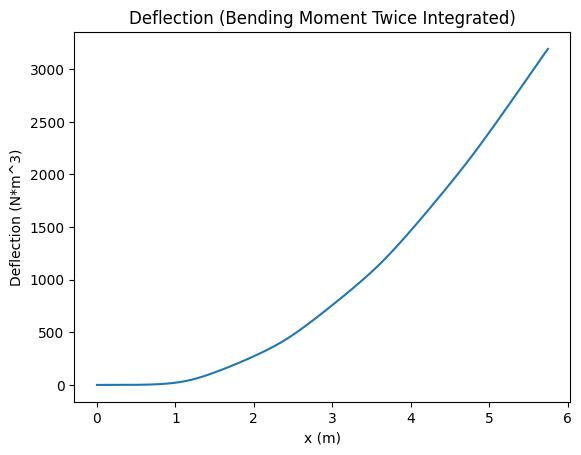

In [196]:
# Deflection for now <?>

# Convert x to m
x = [i / 1000 for i in x]

# Integrate a matplotlib graph
# xList and yList are from matplotlib graph
# C is the integration constant
def integrate(yList, xList, C):
    # The function starts at C
    output = [C]
    for i in range(len(xList) - 1):
        riemannHeight = yList[i+1] + yList[i] / 2
        riemannWidth = xList[i+1] - xList[i]
        output.append(output[i] + (riemannHeight * riemannWidth))
    return output


# Integrate to find slope
slope = integrate(moment, x, 0)

# Plot slope
plt.plot(x,slope)
plt.title("Slope (Bending Moment Once Integrated)")
plt.xlabel('x (m)')
plt.ylabel('Slope (N*m^2)')
plt.show()

# Integrate to find deflection
deflection = integrate(slope, x, 0)

# Plot Deflection
plt.plot(x,deflection)
plt.title("Deflection (Bending Moment Twice Integrated)")
plt.xlabel('x (m)')
plt.ylabel('Deflection (N*m^3)')
plt.show()
